<a href="https://colab.research.google.com/github/lelouch0204/flow-time-series/blob/main/timeseries_darts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install darts

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import seaborn as sns
import plotly.express as px
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf 
from torch.utils.tensorboard import SummaryWriter
import darts
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, Mapper, InvertibleMapper
from darts.dataprocessing import Pipeline
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.utils.timeseries_generation import linear_timeseries

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
os.chdir('/content/drive/MyDrive/SOP work')

In [ ]:
!ls

nitrate_nitrite_aitkin.csv  nitrate_nitrite_stclair.csv
nitrate_nitrite_judson.csv  tft_6_10.pth.tar


In [ ]:
data_path = '/content/drive/MyDrive/SOP work/nitrate_nitrite_judson.csv'
df = pd.read_csv(data_path)
df = df[df['units']=='Daily Conc. (mg/L)']
df.head()
df.info()
data = [df["Ts Date"], df['Flow (cfs)'], df['Ts Value']]
headers = ["ts_date", "flow_cfs", 'ts_value']
df_rel = pd.concat(data, axis=1, keys=headers)
df_rel["date"] = pd.to_datetime(df_rel['ts_date'])
df_rel = df_rel.sort_values(by='date')
df_rel.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4383 entries, 2146 to 8765
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Station name        4383 non-null   object 
 1   Station number      4383 non-null   object 
 2   Station type        4383 non-null   object 
 3   Parameter           4383 non-null   object 
 4   Ts Date             4383 non-null   object 
 5   units               4383 non-null   object 
 6   Flow (cfs)          4383 non-null   int64  
 7   Month               4383 non-null   int64  
 8   Qc Desc             4383 non-null   object 
 9   year                4383 non-null   int64  
 10  Site name / number  4383 non-null   object 
 11  Parameter measure   4383 non-null   object 
 12  Var Des             4383 non-null   object 
 13  Var Id              4383 non-null   int64  
 14  Ts Value            4383 non-null   float64
dtypes: float64(1), int64(4), object(10)
memory usage: 54

,ts_date,flow_cfs,ts_value,date
6109,01-01-2008,863,0.473,2008-01-01
6110,01-02-2008,886,0.490,2008-01-02
6111,01-03-2008,887,0.488,2008-01-03
6112,01-04-2008,919,0.509,2008-01-04
6113,01-05-2008,942,0.525,2008-01-05


In [ ]:
series = TimeSeries.from_dataframe(df_rel, time_col='date', value_cols=['flow_cfs', 'ts_value'])

In [ ]:
scaler = Scaler()
rescaled = scaler.fit_transform(series)
print(rescaled)

<TimeSeries (DataArray) (date: 4383, component: 2, sample: 1)>
array([[[0.01517868],
        [0.02702225]],

       [[0.01564728],
        [0.02802308]],

       [[0.01566766],
        [0.02790533]],

       ...,

       [[0.12126645],
        [0.23113152]],

       [[0.12391508],
        [0.23113152]],

       [[0.12371134],
        [0.23172024]]])
Coordinates:
  * date       (date) datetime64[ns] 2008-01-01 2008-01-02 ... 2019-12-31
  * component  (component) object 'flow_cfs' 'ts_value'
Dimensions without coordinates: sample


In [ ]:
back = scaler.inverse_transform(rescaled)
print(back)

<TimeSeries (DataArray) (date: 4383, component: 2, sample: 1)>
array([[[8.63e+02],
        [4.73e-01]],

       [[8.86e+02],
        [4.90e-01]],

       [[8.87e+02],
        [4.88e-01]],

       ...,

       [[6.07e+03],
        [3.94e+00]],

       [[6.20e+03],
        [3.94e+00]],

       [[6.19e+03],
        [3.95e+00]]])
Coordinates:
  * date       (date) datetime64[ns] 2008-01-01 2008-01-02 ... 2019-12-31
  * component  (component) object 'flow_cfs' 'ts_value'
Dimensions without coordinates: sample


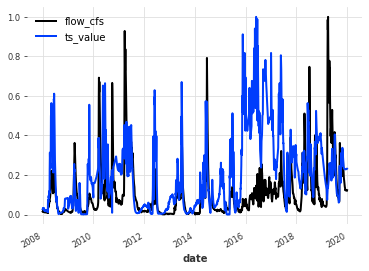

In [ ]:
filler = MissingValuesFiller()
filled = filler.transform(rescaled, method='quadratic')

filled.plot()

# LSTM Model

In [ ]:
train_series = filled[:int(0.8*len(filled))]
val_series = filled[int(0.8*len(filled)):]

In [ ]:
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel

lstm_model = BlockRNNModel(
    model='LSTM',
    input_chunk_length=6,
    output_chunk_length=1,
    hidden_size=15,
    n_rnn_layers=3,
    batch_size=32,
    n_epochs=300,
    dropout=0.1,
    model_name='lstm_6',
    nr_epochs_val_period=1,
    optimizer_kwargs={'lr': 1e-3},
    log_tensorboard=True,
    random_state=42,
    force_reset=True
)

lstm_model.fit(train_series, val_series=val_series, verbose=True)

[2021-12-15 18:08:21,545] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3500 samples.
[2021-12-15 18:08:21,545] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3500 samples.
[2021-12-15 18:08:21,553] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 18:08:21,553] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  0%|          | 1/300 [00:01<06:36,  1.33s/it]

  1%|          | 2/300 [00:03<07:37,  1.53s/it]

  1%|          | 3/300 [00:04<07:14,  1.46s/it]

  1%|▏         | 4/300 [00:05<06:55,  1.40s/it]

  2%|▏         | 5/300 [00:07<06:44,  1.37s/it]

  2%|▏         | 6/300 [00:08<07:21,  1.50s/it]

  2%|▏         | 7/300 [00:10<07:01,  1.44s/it]

  3%|▎         | 8/300 [00:11<06:50,  1.41s/it]

  3%|▎         | 9/300 [00:12<06:39,  1.37s/it]

  3%|▎         | 10/300 [00:14<07:09,  1.48s/it]

  4%|▎         | 11/300 [00:15<06:54,  1.43s/it]

  4%|▍         | 12/300 [00:17<06:42,  1.40s/it]

  4%|▍         | 13/300 [00:18<06:34,  1.38s/it]

  5%|▍         | 14/300 [00:20<06:54,  1.45s/it]

  5%|▌         | 15/300 [00:21<06:46,  1.43s/it]

  5%|▌         | 16/300 [00:22<06:33,  1.38s/it]

  6%|▌         | 17/300 [00:24<06:26,  1.37s/it]

  6%|▌         | 18/300 [00:25<06:23,  1.36s/it]

  6%|▋         | 19/300 [00:27<06:49,  1.46s/it]

  7%|▋         | 20/300 [00:28<07:20,  1.57s/it]

  7%|▋         | 21/300 [00:30<07:31,  1.62s/it]

  7%|▋         | 22/300 [00:31<07:06,  1.53s/it]

  8%|▊         | 23/300 [00:33<06:51,  1.49s/it]

  8%|▊         | 24/300 [00:34<06:43,  1.46s/it]

  8%|▊         | 25/300 [00:35<06:27,  1.41s/it]

  9%|▊         | 26/300 [00:37<06:16,  1.38s/it]

  9%|▉         | 27/300 [00:38<06:39,  1.46s/it]

  9%|▉         | 28/300 [00:40<06:29,  1.43s/it]

 10%|▉         | 29/300 [00:41<06:25,  1.42s/it]

 10%|█         | 30/300 [00:43<06:14,  1.39s/it]

 10%|█         | 31/300 [00:44<06:22,  1.42s/it]

 11%|█         | 32/300 [00:45<06:11,  1.39s/it]

 11%|█         | 33/300 [00:47<06:02,  1.36s/it]

 11%|█▏        | 34/300 [00:48<06:13,  1.41s/it]

 12%|█▏        | 35/300 [00:49<06:05,  1.38s/it]

 12%|█▏        | 36/300 [00:51<05:56,  1.35s/it]

 12%|█▏        | 37/300 [00:52<05:55,  1.35s/it]

 13%|█▎        | 38/300 [00:54<06:12,  1.42s/it]

 13%|█▎        | 39/300 [00:55<06:03,  1.39s/it]

 13%|█▎        | 40/300 [00:56<05:57,  1.37s/it]

 14%|█▎        | 41/300 [00:58<05:50,  1.35s/it]

 14%|█▍        | 42/300 [00:59<06:01,  1.40s/it]

 14%|█▍        | 43/300 [01:00<05:53,  1.37s/it]

 15%|█▍        | 44/300 [01:02<05:45,  1.35s/it]

 15%|█▌        | 45/300 [01:03<05:42,  1.34s/it]

 15%|█▌        | 46/300 [01:05<05:52,  1.39s/it]

 16%|█▌        | 47/300 [01:06<05:45,  1.36s/it]

 16%|█▌        | 48/300 [01:07<05:52,  1.40s/it]

 16%|█▋        | 49/300 [01:09<05:46,  1.38s/it]

 17%|█▋        | 50/300 [01:10<05:44,  1.38s/it]

 17%|█▋        | 51/300 [01:11<05:39,  1.36s/it]

 17%|█▋        | 52/300 [01:13<05:48,  1.40s/it]

 18%|█▊        | 53/300 [01:14<05:39,  1.38s/it]

 18%|█▊        | 54/300 [01:16<05:35,  1.36s/it]

 18%|█▊        | 55/300 [01:17<05:28,  1.34s/it]

 19%|█▊        | 56/300 [01:18<05:24,  1.33s/it]

 19%|█▉        | 57/300 [01:20<05:35,  1.38s/it]

 19%|█▉        | 58/300 [01:21<05:28,  1.36s/it]

 20%|█▉        | 59/300 [01:22<05:22,  1.34s/it]

 20%|██        | 60/300 [01:24<05:34,  1.40s/it]

 20%|██        | 61/300 [01:25<05:28,  1.37s/it]

 21%|██        | 62/300 [01:26<05:20,  1.35s/it]

 21%|██        | 63/300 [01:28<05:25,  1.37s/it]

 21%|██▏       | 64/300 [01:29<05:23,  1.37s/it]

 22%|██▏       | 65/300 [01:31<05:18,  1.35s/it]

 22%|██▏       | 66/300 [01:32<05:22,  1.38s/it]

 22%|██▏       | 67/300 [01:33<05:21,  1.38s/it]

 23%|██▎       | 68/300 [01:35<05:12,  1.35s/it]

 23%|██▎       | 69/300 [01:36<05:06,  1.33s/it]

 23%|██▎       | 70/300 [01:37<05:17,  1.38s/it]

 24%|██▎       | 71/300 [01:39<05:09,  1.35s/it]

 24%|██▍       | 72/300 [01:40<05:03,  1.33s/it]

 24%|██▍       | 73/300 [01:41<05:01,  1.33s/it]

 25%|██▍       | 74/300 [01:43<04:59,  1.33s/it]

 25%|██▌       | 75/300 [01:44<05:09,  1.38s/it]

 25%|██▌       | 76/300 [01:45<05:04,  1.36s/it]

 26%|██▌       | 77/300 [01:47<04:59,  1.34s/it]

 26%|██▌       | 78/300 [01:48<04:55,  1.33s/it]

 26%|██▋       | 79/300 [01:50<05:06,  1.39s/it]

 27%|██▋       | 80/300 [01:51<04:58,  1.36s/it]

 27%|██▋       | 81/300 [01:52<04:54,  1.35s/it]

 27%|██▋       | 82/300 [01:53<04:51,  1.33s/it]

 28%|██▊       | 83/300 [01:55<05:00,  1.39s/it]

 28%|██▊       | 84/300 [01:56<04:55,  1.37s/it]

 28%|██▊       | 85/300 [01:58<04:50,  1.35s/it]

 29%|██▊       | 86/300 [01:59<04:44,  1.33s/it]

 29%|██▉       | 87/300 [02:00<04:53,  1.38s/it]

 29%|██▉       | 88/300 [02:02<04:49,  1.36s/it]

 30%|██▉       | 89/300 [02:03<04:47,  1.36s/it]

 30%|███       | 90/300 [02:04<04:42,  1.35s/it]

 30%|███       | 91/300 [02:06<04:50,  1.39s/it]

 31%|███       | 92/300 [02:07<04:47,  1.38s/it]

 31%|███       | 93/300 [02:09<04:41,  1.36s/it]

 31%|███▏      | 94/300 [02:10<04:38,  1.35s/it]

 32%|███▏      | 95/300 [02:11<04:46,  1.40s/it]

 32%|███▏      | 96/300 [02:13<04:39,  1.37s/it]

 32%|███▏      | 97/300 [02:14<04:34,  1.35s/it]

 33%|███▎      | 98/300 [02:15<04:29,  1.34s/it]

 33%|███▎      | 99/300 [02:17<04:35,  1.37s/it]

 33%|███▎      | 100/300 [02:18<04:30,  1.35s/it]

 34%|███▎      | 101/300 [02:19<04:26,  1.34s/it]

 34%|███▍      | 102/300 [02:21<04:22,  1.33s/it]

 34%|███▍      | 103/300 [02:22<04:29,  1.37s/it]

 35%|███▍      | 104/300 [02:23<04:27,  1.37s/it]

 35%|███▌      | 105/300 [02:25<04:23,  1.35s/it]

 35%|███▌      | 106/300 [02:26<04:21,  1.35s/it]

 36%|███▌      | 107/300 [02:28<04:22,  1.36s/it]

 36%|███▌      | 108/300 [02:29<04:27,  1.39s/it]

 36%|███▋      | 109/300 [02:30<04:23,  1.38s/it]

 37%|███▋      | 110/300 [02:32<04:16,  1.35s/it]

 37%|███▋      | 111/300 [02:33<04:12,  1.34s/it]

 37%|███▋      | 112/300 [02:34<04:21,  1.39s/it]

 38%|███▊      | 113/300 [02:36<04:13,  1.36s/it]

 38%|███▊      | 114/300 [02:37<04:09,  1.34s/it]

 38%|███▊      | 115/300 [02:38<04:06,  1.33s/it]

 39%|███▊      | 116/300 [02:40<04:04,  1.33s/it]

 39%|███▉      | 117/300 [02:41<04:16,  1.40s/it]

 39%|███▉      | 118/300 [02:43<04:11,  1.38s/it]

 40%|███▉      | 119/300 [02:44<04:05,  1.36s/it]

 40%|████      | 120/300 [02:45<04:01,  1.34s/it]

 40%|████      | 121/300 [02:46<03:58,  1.33s/it]

 41%|████      | 122/300 [02:48<04:04,  1.37s/it]

 41%|████      | 123/300 [02:49<03:59,  1.35s/it]

 41%|████▏     | 124/300 [02:51<03:55,  1.34s/it]

 42%|████▏     | 125/300 [02:52<03:51,  1.32s/it]

 42%|████▏     | 126/300 [02:53<03:50,  1.32s/it]

 42%|████▏     | 127/300 [02:55<03:58,  1.38s/it]

 43%|████▎     | 128/300 [02:56<03:53,  1.36s/it]

 43%|████▎     | 129/300 [02:57<03:49,  1.34s/it]

 43%|████▎     | 130/300 [02:59<03:45,  1.33s/it]

 44%|████▎     | 131/300 [03:00<03:52,  1.38s/it]

 44%|████▍     | 132/300 [03:01<03:47,  1.35s/it]

 44%|████▍     | 133/300 [03:03<03:43,  1.34s/it]

 45%|████▍     | 134/300 [03:04<03:41,  1.33s/it]

 45%|████▌     | 135/300 [03:05<03:39,  1.33s/it]

 45%|████▌     | 136/300 [03:07<03:46,  1.38s/it]

 46%|████▌     | 137/300 [03:08<03:43,  1.37s/it]

 46%|████▌     | 138/300 [03:10<03:40,  1.36s/it]

 46%|████▋     | 139/300 [03:11<03:37,  1.35s/it]

 47%|████▋     | 140/300 [03:12<03:34,  1.34s/it]

 47%|████▋     | 141/300 [03:14<03:40,  1.39s/it]

 47%|████▋     | 142/300 [03:15<03:35,  1.36s/it]

 48%|████▊     | 143/300 [03:16<03:30,  1.34s/it]

 48%|████▊     | 144/300 [03:18<03:27,  1.33s/it]

 48%|████▊     | 145/300 [03:19<03:24,  1.32s/it]

 49%|████▊     | 146/300 [03:20<03:31,  1.37s/it]

 49%|████▉     | 147/300 [03:22<03:28,  1.36s/it]

 49%|████▉     | 148/300 [03:23<03:26,  1.36s/it]

 50%|████▉     | 149/300 [03:24<03:25,  1.36s/it]

 50%|█████     | 150/300 [03:26<03:26,  1.38s/it]

 50%|█████     | 151/300 [03:27<03:27,  1.39s/it]

 51%|█████     | 152/300 [03:29<03:22,  1.37s/it]

 51%|█████     | 153/300 [03:30<03:18,  1.35s/it]

 51%|█████▏    | 154/300 [03:31<03:15,  1.34s/it]

 52%|█████▏    | 155/300 [03:33<03:21,  1.39s/it]

 52%|█████▏    | 156/300 [03:34<03:15,  1.36s/it]

 52%|█████▏    | 157/300 [03:35<03:11,  1.34s/it]

 53%|█████▎    | 158/300 [03:37<03:08,  1.33s/it]

 53%|█████▎    | 159/300 [03:38<03:05,  1.32s/it]

 53%|█████▎    | 160/300 [03:39<03:04,  1.32s/it]

 54%|█████▎    | 161/300 [03:41<03:11,  1.38s/it]

 54%|█████▍    | 162/300 [03:42<03:06,  1.35s/it]

 54%|█████▍    | 163/300 [03:43<03:03,  1.34s/it]

 55%|█████▍    | 164/300 [03:45<02:59,  1.32s/it]

 55%|█████▌    | 165/300 [03:46<02:57,  1.32s/it]

 55%|█████▌    | 166/300 [03:47<03:03,  1.37s/it]

 56%|█████▌    | 167/300 [03:49<02:59,  1.35s/it]

 56%|█████▌    | 168/300 [03:50<02:55,  1.33s/it]

 56%|█████▋    | 169/300 [03:51<02:52,  1.32s/it]

 57%|█████▋    | 170/300 [03:53<02:58,  1.38s/it]

 57%|█████▋    | 171/300 [03:54<02:54,  1.35s/it]

 57%|█████▋    | 172/300 [03:55<02:51,  1.34s/it]

 58%|█████▊    | 173/300 [03:57<02:49,  1.33s/it]

 58%|█████▊    | 174/300 [03:58<02:46,  1.32s/it]

 58%|█████▊    | 175/300 [03:59<02:52,  1.38s/it]

 59%|█████▊    | 176/300 [04:01<02:49,  1.36s/it]

 59%|█████▉    | 177/300 [04:02<02:45,  1.35s/it]

 59%|█████▉    | 178/300 [04:03<02:43,  1.34s/it]

 60%|█████▉    | 179/300 [04:05<02:47,  1.39s/it]

 60%|██████    | 180/300 [04:06<02:43,  1.36s/it]

 60%|██████    | 181/300 [04:08<02:40,  1.35s/it]

 61%|██████    | 182/300 [04:09<02:37,  1.33s/it]

 61%|██████    | 183/300 [04:10<02:35,  1.33s/it]

 61%|██████▏   | 184/300 [04:12<02:41,  1.39s/it]

 62%|██████▏   | 185/300 [04:13<02:36,  1.37s/it]

 62%|██████▏   | 186/300 [04:14<02:33,  1.34s/it]

 62%|██████▏   | 187/300 [04:16<02:30,  1.34s/it]

 63%|██████▎   | 188/300 [04:17<02:28,  1.32s/it]

 63%|██████▎   | 189/300 [04:18<02:33,  1.38s/it]

 63%|██████▎   | 190/300 [04:20<02:29,  1.36s/it]

 64%|██████▎   | 191/300 [04:21<02:27,  1.35s/it]

 64%|██████▍   | 192/300 [04:22<02:24,  1.34s/it]

 64%|██████▍   | 193/300 [04:24<02:22,  1.33s/it]

 65%|██████▍   | 194/300 [04:25<02:22,  1.35s/it]

 65%|██████▌   | 195/300 [04:26<02:21,  1.35s/it]

 65%|██████▌   | 196/300 [04:28<02:18,  1.33s/it]

 66%|██████▌   | 197/300 [04:29<02:23,  1.39s/it]

 66%|██████▌   | 198/300 [04:31<02:20,  1.37s/it]

 66%|██████▋   | 199/300 [04:32<02:16,  1.35s/it]

 67%|██████▋   | 200/300 [04:33<02:14,  1.35s/it]

 67%|██████▋   | 201/300 [04:35<02:12,  1.34s/it]

 67%|██████▋   | 202/300 [04:36<02:15,  1.38s/it]

 68%|██████▊   | 203/300 [04:37<02:13,  1.38s/it]

 68%|██████▊   | 204/300 [04:39<02:10,  1.36s/it]

 68%|██████▊   | 205/300 [04:40<02:07,  1.34s/it]

 69%|██████▊   | 206/300 [04:41<02:05,  1.33s/it]

 69%|██████▉   | 207/300 [04:43<02:07,  1.37s/it]

 69%|██████▉   | 208/300 [04:44<02:06,  1.37s/it]

 70%|██████▉   | 209/300 [04:45<02:03,  1.35s/it]

 70%|███████   | 210/300 [04:47<01:59,  1.33s/it]

 70%|███████   | 211/300 [04:48<01:58,  1.33s/it]

 71%|███████   | 212/300 [04:49<01:57,  1.33s/it]

 71%|███████   | 213/300 [04:51<01:59,  1.38s/it]

 71%|███████▏  | 214/300 [04:52<01:56,  1.36s/it]

 72%|███████▏  | 215/300 [04:54<01:54,  1.35s/it]

 72%|███████▏  | 216/300 [04:55<01:53,  1.35s/it]

 72%|███████▏  | 217/300 [04:57<02:15,  1.63s/it]

 73%|███████▎  | 218/300 [04:59<02:10,  1.59s/it]

 73%|███████▎  | 219/300 [05:00<02:02,  1.51s/it]

 73%|███████▎  | 220/300 [05:02<02:01,  1.52s/it]

 74%|███████▎  | 221/300 [05:03<01:57,  1.48s/it]

 74%|███████▍  | 222/300 [05:04<01:52,  1.44s/it]

 74%|███████▍  | 223/300 [05:06<01:49,  1.42s/it]

 75%|███████▍  | 224/300 [05:07<01:47,  1.42s/it]

 75%|███████▌  | 225/300 [05:09<01:46,  1.42s/it]

 75%|███████▌  | 226/300 [05:10<01:45,  1.43s/it]

 76%|███████▌  | 227/300 [05:11<01:43,  1.42s/it]

 76%|███████▌  | 228/300 [05:13<01:40,  1.40s/it]

 76%|███████▋  | 229/300 [05:14<01:38,  1.39s/it]

 77%|███████▋  | 230/300 [05:15<01:37,  1.40s/it]

 77%|███████▋  | 231/300 [05:17<01:37,  1.41s/it]

 77%|███████▋  | 232/300 [05:18<01:36,  1.41s/it]

 78%|███████▊  | 233/300 [05:20<01:34,  1.41s/it]

 78%|███████▊  | 234/300 [05:21<01:33,  1.41s/it]

 78%|███████▊  | 235/300 [05:23<01:31,  1.41s/it]

 79%|███████▊  | 236/300 [05:24<01:29,  1.40s/it]

 79%|███████▉  | 237/300 [05:25<01:29,  1.42s/it]

 79%|███████▉  | 238/300 [05:27<01:27,  1.41s/it]

 80%|███████▉  | 239/300 [05:28<01:25,  1.41s/it]

 80%|████████  | 240/300 [05:30<01:23,  1.40s/it]

 80%|████████  | 241/300 [05:31<01:23,  1.41s/it]

 81%|████████  | 242/300 [05:32<01:21,  1.41s/it]

 81%|████████  | 243/300 [05:34<01:20,  1.41s/it]

 81%|████████▏ | 244/300 [05:35<01:18,  1.40s/it]

 82%|████████▏ | 245/300 [05:37<01:17,  1.41s/it]

 82%|████████▏ | 246/300 [05:38<01:16,  1.41s/it]

 82%|████████▏ | 247/300 [05:39<01:15,  1.42s/it]

 83%|████████▎ | 248/300 [05:41<01:14,  1.44s/it]

 83%|████████▎ | 249/300 [05:42<01:12,  1.42s/it]

 83%|████████▎ | 250/300 [05:44<01:10,  1.42s/it]

 84%|████████▎ | 251/300 [05:45<01:09,  1.42s/it]

 84%|████████▍ | 252/300 [05:47<01:07,  1.42s/it]

 84%|████████▍ | 253/300 [05:48<01:07,  1.43s/it]

 85%|████████▍ | 254/300 [05:49<01:05,  1.43s/it]

 85%|████████▌ | 255/300 [05:51<01:02,  1.39s/it]

 85%|████████▌ | 256/300 [05:52<01:00,  1.39s/it]

 86%|████████▌ | 257/300 [05:54<01:00,  1.40s/it]

 86%|████████▌ | 258/300 [05:55<01:00,  1.43s/it]

 86%|████████▋ | 259/300 [05:56<00:58,  1.42s/it]

 87%|████████▋ | 260/300 [05:58<00:56,  1.42s/it]

 87%|████████▋ | 261/300 [05:59<00:55,  1.44s/it]

 87%|████████▋ | 262/300 [06:01<00:55,  1.46s/it]

 88%|████████▊ | 263/300 [06:02<00:54,  1.48s/it]

 88%|████████▊ | 264/300 [06:04<00:52,  1.46s/it]

 88%|████████▊ | 265/300 [06:05<00:51,  1.47s/it]

 89%|████████▊ | 266/300 [06:07<00:50,  1.49s/it]

 89%|████████▉ | 267/300 [06:08<00:49,  1.50s/it]

 89%|████████▉ | 268/300 [06:10<00:47,  1.48s/it]

 90%|████████▉ | 269/300 [06:11<00:45,  1.48s/it]

 90%|█████████ | 270/300 [06:13<00:45,  1.50s/it]

 90%|█████████ | 271/300 [06:14<00:43,  1.50s/it]

 91%|█████████ | 272/300 [06:16<00:42,  1.50s/it]

 91%|█████████ | 273/300 [06:17<00:39,  1.48s/it]

 91%|█████████▏| 274/300 [06:19<00:39,  1.50s/it]

 92%|█████████▏| 275/300 [06:20<00:37,  1.51s/it]

 92%|█████████▏| 276/300 [06:22<00:36,  1.50s/it]

 92%|█████████▏| 277/300 [06:23<00:34,  1.51s/it]

 93%|█████████▎| 278/300 [06:25<00:33,  1.51s/it]

 93%|█████████▎| 279/300 [06:26<00:31,  1.51s/it]

 93%|█████████▎| 280/300 [06:28<00:30,  1.51s/it]

 94%|█████████▎| 281/300 [06:29<00:28,  1.53s/it]

 94%|█████████▍| 282/300 [06:31<00:27,  1.51s/it]

 94%|█████████▍| 283/300 [06:32<00:25,  1.50s/it]

 95%|█████████▍| 284/300 [06:34<00:23,  1.49s/it]

 95%|█████████▌| 285/300 [06:35<00:22,  1.50s/it]

 95%|█████████▌| 286/300 [06:37<00:20,  1.48s/it]

 96%|█████████▌| 287/300 [06:38<00:19,  1.50s/it]

 96%|█████████▌| 288/300 [06:40<00:18,  1.51s/it]

 96%|█████████▋| 289/300 [06:41<00:16,  1.51s/it]

 97%|█████████▋| 290/300 [06:43<00:14,  1.50s/it]

 97%|█████████▋| 291/300 [06:44<00:13,  1.49s/it]

 97%|█████████▋| 292/300 [06:46<00:11,  1.50s/it]

 98%|█████████▊| 293/300 [06:47<00:10,  1.49s/it]

 98%|█████████▊| 294/300 [06:49<00:09,  1.50s/it]

 98%|█████████▊| 295/300 [06:50<00:07,  1.52s/it]

 99%|█████████▊| 296/300 [06:52<00:06,  1.51s/it]

 99%|█████████▉| 297/300 [06:53<00:04,  1.50s/it]

 99%|█████████▉| 298/300 [06:55<00:03,  1.54s/it]

100%|█████████▉| 299/300 [06:57<00:01,  1.54s/it]

100%|██████████| 300/300 [06:58<00:00,  1.40s/it]

In [ ]:
train_len = int(0.8*len(filled))
filled[train_len]

<TimeSeries (DataArray) (date: 1, component: 2, sample: 1)>
array([[[0.03100933],
        [0.02596256]]])
Coordinates:
  * date       (date) datetime64[ns] 2017-08-07
  * component  (component) object 'flow_cfs' 'ts_value'
Dimensions without coordinates: sample

In [ ]:
pred_series = lstm_model.historical_forecasts(filled,
                                                start=pd.Timestamp('2017-08-07'),
                                                forecast_horizon=2,
                                                stride=1,
                                                retrain=False,
                                                last_points_only=True,
                                                verbose=True)

100%|██████████| 876/876 [00:14<00:00, 60.54it/s]


LSTM MAPE: 11.765586515041457


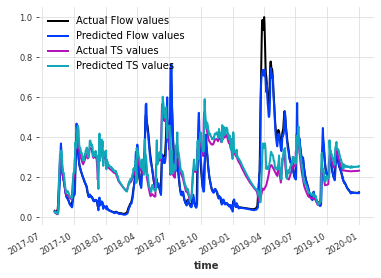

In [ ]:
filled['flow_cfs'][train_len:].plot(label='Actual Flow values')
pred_series['0'].plot(label='Predicted Flow values')
filled['ts_value'][train_len:].plot(label='Actual TS values')
pred_series['1'].plot(label='Predicted TS values')
print("LSTM MAPE:", mape(pred_series, filled[train_len:]))

# Transformers

[2021-12-15 19:42:48,391] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3494 samples.
[2021-12-15 19:42:48,391] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3494 samples.
[2021-12-15 19:42:48,418] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 19:42:48,418] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  0%|          | 1/400 [00:09<1:04:48,  9.75s/it]

  3%|▎         | 11/400 [01:39<59:15,  9.14s/it]

  5%|▌         | 21/400 [03:09<57:58,  9.18s/it]

  8%|▊         | 31/400 [04:38<55:45,  9.07s/it]

 10%|█         | 41/400 [06:11<58:10,  9.72s/it]

 13%|█▎        | 51/400 [07:40<52:43,  9.07s/it]

 15%|█▌        | 61/400 [09:09<51:14,  9.07s/it]

 18%|█▊        | 71/400 [10:38<49:38,  9.05s/it]

 20%|██        | 81/400 [12:07<48:03,  9.04s/it]

 23%|██▎       | 91/400 [13:36<46:24,  9.01s/it]

 25%|██▌       | 101/400 [15:05<45:10,  9.06s/it]

 28%|██▊       | 111/400 [16:34<43:32,  9.04s/it]

 30%|███       | 121/400 [18:04<42:12,  9.08s/it]

 33%|███▎      | 131/400 [19:33<40:25,  9.02s/it]

 35%|███▌      | 141/400 [21:02<38:56,  9.02s/it]

 38%|███▊      | 151/400 [22:30<37:17,  8.99s/it]

 40%|████      | 161/400 [23:59<36:00,  9.04s/it]

 43%|████▎     | 171/400 [25:28<34:29,  9.04s/it]

 45%|████▌     | 181/400 [27:01<33:43,  9.24s/it]

 48%|████▊     | 191/400 [28:30<31:36,  9.07s/it]

 50%|█████     | 201/400 [30:01<30:24,  9.17s/it]

 53%|█████▎    | 211/400 [31:30<28:34,  9.07s/it]

 55%|█████▌    | 221/400 [33:00<27:15,  9.14s/it]

 58%|█████▊    | 231/400 [34:30<25:49,  9.17s/it]

 60%|██████    | 241/400 [36:01<24:26,  9.22s/it]

 63%|██████▎   | 251/400 [37:31<22:46,  9.17s/it]

 65%|██████▌   | 261/400 [39:01<21:11,  9.15s/it]

 68%|██████▊   | 271/400 [40:31<19:34,  9.11s/it]

 70%|███████   | 281/400 [42:02<18:22,  9.27s/it]

 73%|███████▎  | 291/400 [43:32<16:36,  9.14s/it]

 75%|███████▌  | 301/400 [45:02<15:08,  9.18s/it]

 78%|███████▊  | 311/400 [46:33<13:35,  9.16s/it]

 80%|████████  | 321/400 [48:10<12:32,  9.53s/it]

 83%|████████▎ | 331/400 [49:42<10:47,  9.38s/it]

 85%|████████▌ | 341/400 [51:13<09:05,  9.25s/it]

 88%|████████▊ | 351/400 [52:44<07:28,  9.16s/it]

 90%|█████████ | 361/400 [54:15<06:04,  9.36s/it]

 93%|█████████▎| 371/400 [55:46<04:28,  9.26s/it]

 95%|█████████▌| 381/400 [57:17<02:55,  9.23s/it]

 98%|█████████▊| 391/400 [58:48<01:22,  9.21s/it]

100%|██████████| 876/876 [00:20<00:00, 42.97it/s]


Transforers MAPE: 16.67950692466155


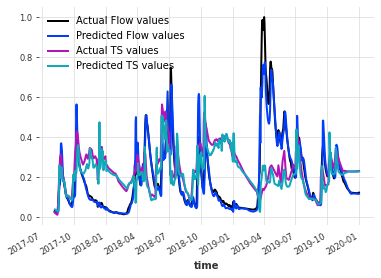

In [ ]:
from darts.models import TransformerModel

transformer_model = TransformerModel(
    input_chunk_length = 12,
    output_chunk_length = 1,
    batch_size = 32,
    n_epochs = 400,
    model_name = 'transformer_12',
    log_tensorboard=True,
    nr_epochs_val_period = 10,
    force_reset=True,
    d_model = 32,
    nhead = 16,
    num_encoder_layers = 4,
    num_decoder_layers = 4,
    dim_feedforward = 512,
    dropout = 0.1,
    activation = "relu",
    random_state=42,
    save_checkpoints=True
)

transformer_model.fit(train_series, val_series=val_series, verbose=True)

pred_series_transformer = transformer_model.historical_forecasts(filled,
                                                start=pd.Timestamp('2017-08-07'),
                                                forecast_horizon=2,
                                                stride=1,
                                                retrain=False,
                                                last_points_only=True,
                                                verbose=True)

filled['flow_cfs'][train_len:].plot(label='Actual Flow values')
pred_series_transformer['0'].plot(label='Predicted Flow values')
filled['ts_value'][train_len:].plot(label='Actual TS values')
pred_series_transformer['1'].plot(label='Predicted TS values')
print("Transforers MAPE:", mape(pred_series_transformer, filled[train_len:]))

Transforers MAPE: 16.67950692466155


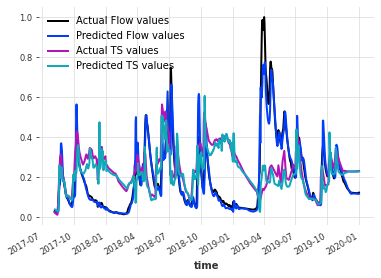

In [ ]:
filled['flow_cfs'][train_len:].plot(label='Actual Flow values')
pred_series_transformer['0'].plot(label='Predicted Flow values')
filled['ts_value'][train_len:].plot(label='Actual TS values')
pred_series_transformer['1'].plot(label='Predicted TS values')
print("Transforers MAPE:", mape(pred_series_transformer, filled[train_len:]))

In [ ]:
from darts.models import RandomForest

rf_model = RandomForest(
    lags = 30,
    n_estimators = 10,
    random_state=42
)

rf_model.fit(series=train_series)



In [ ]:
rf_pred = rf_model.historical_forecasts(
    series=filled,
    start = pd.Timestamp('2017-08-07'),
    forecast_horizon=2,
    stride=1,
    retrain=False, 
    last_points_only=True,
    verbose=True
)

100%|██████████| 876/876 [00:28<00:00, 30.88it/s]


Random Forests MAPE: 9.769187247316733


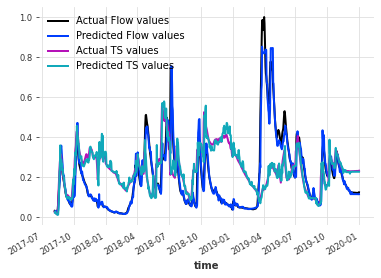

In [ ]:
filled['flow_cfs'][train_len:].plot(label='Actual Flow values')
rf_pred['0'].plot(label='Predicted Flow values')
filled['ts_value'][train_len:].plot(label='Actual TS values')
rf_pred['1'].plot(label='Predicted TS values')
print("Random Forests MAPE:", mape(rf_pred, filled[train_len:]))

In [ ]:
var_params = {
    'lags' : [10, 15, 20, 25, 30, 35, 40, 45, 50],
    'n_estimators' : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
}

rf_grid, rf_params = rf_model.gridsearch(
    parameters = var_params,
    series = train_series,
    stride=1,
    last_points_only=True,
    val_series = val_series,
    verbose=True, 
    metric=mape
)

100%|██████████| 90/90 [23:40<00:00, 15.78s/it]
[2021-12-20 11:49:19,978] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'lags': 40, 'n_estimators': 10}
[2021-12-20 11:49:19,978] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'lags': 40, 'n_estimators': 10}


In [ ]:
rf_grid.fit(train_series)

In [ ]:
rf_grid_pred = rf_grid.historical_forecasts(
    series=filled,
    start = pd.Timestamp('2017-08-07'),
    forecast_horizon=2,
    stride=1,
    retrain=False, 
    last_points_only=True,
    verbose=True
)

100%|██████████| 876/876 [00:17<00:00, 48.79it/s]


Random Forests MAPE: 10.03702493313977


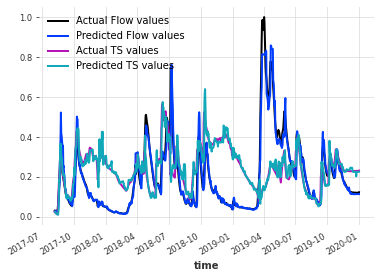

In [ ]:
filled['flow_cfs'][train_len:].plot(label='Actual Flow values')
rf_grid_pred['0'].plot(label='Predicted Flow values')
filled['ts_value'][train_len:].plot(label='Actual TS values')
rf_grid_pred['1'].plot(label='Predicted TS values')
print("Random Forests MAPE:", mape(rf_grid_pred, filled[train_len:]))

# Linear Regression


In [ ]:
from darts.models import LinearRegressionModel

linreg_model = LinearRegressionModel(
    lags = 30
)

linreg_model.fit(train_series)

In [ ]:
linreg_pred = linreg_model.historical_forecasts(
    series=filled,
    start = pd.Timestamp('2017-08-07'),
    forecast_horizon=2,
    stride=1,
    retrain=False, 
    last_points_only=True,
    verbose=True
)

100%|██████████| 876/876 [00:13<00:00, 67.02it/s]


Linear Regression MAPE: 7.901519213644519


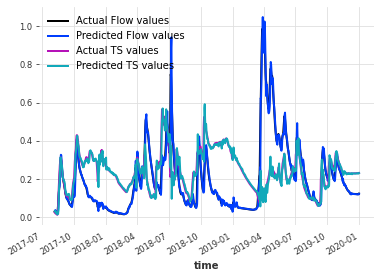

In [ ]:
filled['flow_cfs'][train_len:].plot(label='Actual Flow values')
linreg_pred['0'].plot(label='Predicted Flow values')
filled['ts_value'][train_len:].plot(label='Actual TS values')
linreg_pred['1'].plot(label='Predicted TS values')
print("Linear Regression MAPE:", mape(linreg_pred, filled[train_len:]))